In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
GOOGLE_COLAB = True

In [0]:
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import sys
if GOOGLE_COLAB:
    sys.path.append('drive/My Drive/yelp_sentiment_analysis')
else:
    sys.path.append('../')

from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization
from yelpsent import models

In [0]:
import importlib
def reload():
  importlib.reload(data)
  importlib.reload(features)
  importlib.reload(metrics)
  importlib.reload(visualization)
  importlib.reload(models)

# Load Dataset

In [0]:
if GOOGLE_COLAB:
    data_train, data_test = data.load_dataset("drive/My Drive/yelp_sentiment_analysis/data/yelp_train_balanced.json",
                                              "drive/My Drive/yelp_sentiment_analysis/data/yelp_test.json")
else:
    data_train, data_test = data.load_dataset("../data/yelp_train.json",
                                              "../data/yelp_test.json")

In [0]:
X_train = data_train['review'].tolist()
y_train = data_train['sentiment'].tolist()

In [0]:
X_test = data_test['review'].tolist()
y_test = data_test['sentiment'].tolist()

# Load DTMs

In [0]:
with open('drive/My Drive/yelp_sentiment_analysis/pickles/vectorizer.pickle', 'rb') as f:
    vectorizer = pickle.load(f)

with open('drive/My Drive/yelp_sentiment_analysis/pickles/X_train_dtm.pickle', 'rb') as f:
    X_train_dtm = pickle.load(f)

with open('drive/My Drive/yelp_sentiment_analysis/pickles/X_test_dtm.pickle', 'rb') as f:
    X_test_dtm = pickle.load(f)

# Ordinal Regression

In [11]:
!pip install mord

  Created wheel for mord: filename=mord-0.6-cp36-none-any.whl size=6008 sha256=badbf942ef2c329de741d312f4130b84742b8bf29353ea845e7a22be7997d7d8
  Stored in directory: /root/.cache/pip/wheels/98/14/b2/244c2cec93a0c6edb29b488bd6b2710ded7e9d457033b86366
Successfully built mord


In [0]:
from mord import LogisticAT
from sklearn.model_selection import GridSearchCV

In [61]:
dict(alpha = np.logspace(0, 2, 5))

{'alpha': array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
        100.        ])}

In [0]:
# Grid-search for alpha
params = dict(alpha = np.logspace(0, 2, 5))

gscv = GridSearchCV(LogisticAT(max_iter=1000),
                    params,
                    scoring='f1_macro',
                    cv=3,
                    verbose=1,
                    n_jobs=-1)

In [63]:
gscv.fit(X_train_dtm, np.array(y_train))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  9.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticAT(alpha=1.0, max_iter=1000, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=1)

In [64]:
print(gscv.best_params_)

{'alpha': 1.0}


In [0]:
# Final model
model = LogisticAT(alpha=150)

In [91]:
%time model.fit(X_train_dtm, np.array(y_train))

CPU times: user 2min 29s, sys: 2min 53s, total: 5min 22s
Wall time: 1min 54s


LogisticAT(alpha=150, max_iter=1000, verbose=0)

In [0]:
with open('drive/My Drive/yelp_sentiment_analysis/models/ordinal_regression.pickle', 'wb') as f:
  pickle.dump(model, f)

# with open('drive/My Drive/yelp_sentiment_analysis/models/ordinal_regression.pickle', 'rb') as f:
#   model = pickle.load(f)

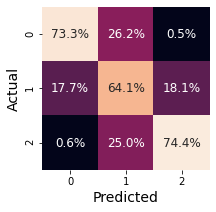

Macro F1 Scores: 
 Training: 0.759 
 Testing: 0.702




In [92]:
y_train_pred, y_test_pred, f1_train, f1_test =\
models.evaluate_pipeline(X_train = X_train_dtm,
                         y_train = y_train,
                         X_test = X_test_dtm,
                         y_test = y_test,
                         pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))